# Analysing my Whatsapp conversations with my daughters

In [1]:

import os
import pandas as pd
import re
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import emoji
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Extract the messages from the text file obtained from Whatsapp the chat.

(Instructions on how to do this can be found [here](https://faq.whatsapp.com/196737011380816/?locale=en_US))

In [2]:
# Extract chat into a list of lists
with open("_chat.txt") as fp:
    dataset = []
    while True:
        line = fp.readline()
        if not line: #make sure there are no blank lines
            break
        
        line = line.strip()
        line = line.strip('\u202C') #get rid of annoying unicode characters
        line = line.strip('\u202A')

        line = line[1:] 
        split = line.split('] ')
        if len(split)>1:
            date_time = split[0] #Strip the date and time
            date = date_time.split(', ')[0]
            time = date_time.split(', ')[1]
            auth_message = split[1].split(': ')
            if len(auth_message)>1:
                author = auth_message[0].strip() #extract the author of the message
                message = auth_message[1].strip() #extract the message text
        dataset.append([date, time, author, message])

#Create Pandas dataframe
df_raw = pd.DataFrame(dataset, columns=['Date', 'Time', 'Author', 'Message'])
df = df_raw.copy()
df


,Date,Time,Author,Message
0,2021/11/25,17:56:05,Chicane,"I wanted to ask you, because we’re seeing chri..."
1,2021/11/25,17:56:19,Mark Stent,i dont think so
2,2021/11/25,17:56:26,Mark Stent,but i do think its time to make peace
3,2021/11/25,17:56:34,Mark Stent,kiara has made peace already
4,2021/11/25,17:57:28,Chicane,i’m not comfortable with seeing granny yet dad...
...,...,...,...,...
2153,2022/08/07,18:52:14,Chicane,love you so much dad
2154,2022/08/07,18:52:17,Skyla-Jean,"we loved seeing you aswell, thank you dad ❤️"
2155,2022/08/09,11:48:00,Mark Stent,happy womans day to the princesses of my life....
2156,2022/08/09,11:49:14,Skyla-Jean,love you dad ❤️


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2158 entries, 0 to 2157
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     2158 non-null   object
 1   Time     2158 non-null   object
 2   Author   2158 non-null   object
 3   Message  2158 non-null   object
dtypes: object(4)
memory usage: 67.6+ KB


The data frame has no null values (shew!) and there are 2158 messages. We need to do some cleaning up to make the dataframe more analysis friendly.

In [4]:

#Work on the dates

df['Date']= df['Date'].str.replace('[', '') #Get rid of any preceeding '[']
df['Date'] = pd.to_datetime(df['Date']) #convert Date columns to date format

#Round the time to the hour it belongs to and create a new column
df['Time_Rounded'] = pd.to_datetime(df['Time']).dt.floor('H').dt.strftime('%I %p')

#Add a day column
days = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thursday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}

df['Day'] = df['Date'].dt.weekday.map(days)
df['Day'] = df['Day'].astype('category') #change datatype of 'Day' column to a category

#Work on Authors
df['Author'] = df['Author'].astype('category') #change datatype of 'Author' column to a category

# Add a column for letter count in each message
df['letters'] = df['Message'].apply(lambda x: len(x))

#create a column for to count the number of images in each message
image_pattern = r'image omitted'
df['Media_image'] = df.Message.apply(lambda x : re.findall(image_pattern, x)).str.len()

#create a column to count the number of voice notes in each message
audio_pattern = r'audio omitted'
df['Media_audio'] = df.Message.apply(lambda x : re.findall(audio_pattern, x)).str.len()

#Find all emojis and extract these into a list
def extract_emojis(text):
  for word in text:
    emojis = emoji.distinct_emoji_list(word)
    stremoj = ' '.join(emojis)

  return stremoj


#Create an Emoji column in the dataframe
df["Emoji"] = df["Message"].apply(extract_emojis)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2158 entries, 0 to 2157
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2158 non-null   datetime64[ns]
 1   Time          2158 non-null   object        
 2   Author        2158 non-null   category      
 3   Message       2158 non-null   object        
 4   Time_Rounded  2158 non-null   object        
 5   Day           2158 non-null   category      
 6   letters       2158 non-null   int64         
 7   Media_image   2158 non-null   int64         
 8   Media_audio   2158 non-null   int64         
 9   Emoji         2158 non-null   object        
dtypes: category(2), datetime64[ns](1), int64(3), object(4)
memory usage: 139.8+ KB


/var/folders/1n/15zl_prj657bn905jj4gn8qr0000gq/T/ipykernel_53512/2888083264.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Date']= df['Date'].str.replace('[', '') #Get rid of any preceeding '[']


In [5]:
df

,Date,Time,Author,Message,Time_Rounded,Day,letters,Media_image,Media_audio,Emoji
0,2021-11-25,17:56:05,Chicane,"I wanted to ask you, because we’re seeing chri...",05 PM,Thursday,106,0,0,
1,2021-11-25,17:56:19,Mark Stent,i dont think so,05 PM,Thursday,15,0,0,
2,2021-11-25,17:56:26,Mark Stent,but i do think its time to make peace,05 PM,Thursday,37,0,0,
3,2021-11-25,17:56:34,Mark Stent,kiara has made peace already,05 PM,Thursday,28,0,0,
4,2021-11-25,17:57:28,Chicane,i’m not comfortable with seeing granny yet dad...,05 PM,Thursday,141,0,0,
...,...,...,...,...,...,...,...,...,...,...
2153,2022-08-07,18:52:14,Chicane,love you so much dad,06 PM,Sunday,20,0,0,
2154,2022-08-07,18:52:17,Skyla-Jean,"we loved seeing you aswell, thank you dad ❤️",06 PM,Sunday,45,0,0,
2155,2022-08-09,11:48:00,Mark Stent,happy womans day to the princesses of my life....,11 AM,Tuesday,127,0,0,
2156,2022-08-09,11:49:14,Skyla-Jean,love you dad ❤️,11 AM,Tuesday,15,0,0,


In [24]:
df['Emoji'].apply(lambda x: len(x))

0       0
1       0
2       0
3       0
4       0
       ..
2153    0
2154    0
2155    0
2156    0
2157    1
Name: Emoji, Length: 2158, dtype: int64

Now that we have a datafram that is in a decent enough format for analysis, lets ask some questions and see how our family chat looks on Whatsapp.

## Who has sent the most messages?

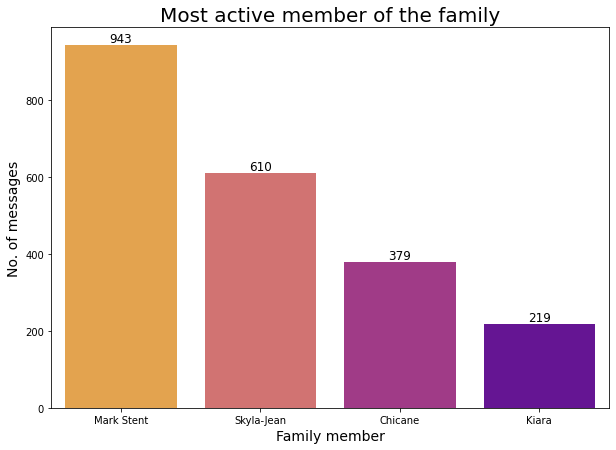

In [6]:
plt.figure(figsize=(10,7))
ax = sns.countplot(data=df, x='Author', order = df['Author'].value_counts().iloc[:4].index, palette='plasma_r')
plt.xlabel('Family member' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Most active member of the family',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12) #annotate bars
plt.show()



## What is the bussiest day for chatting?

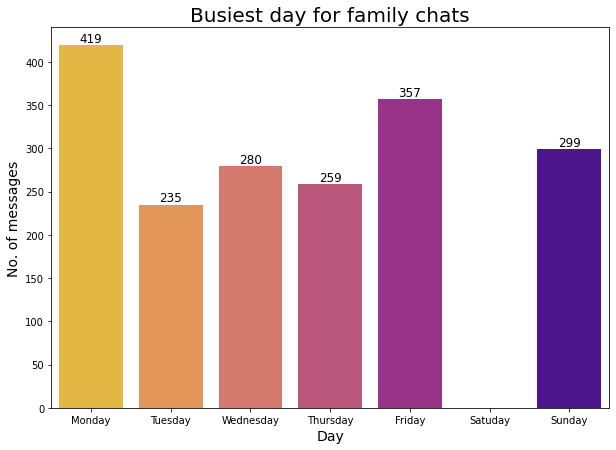

In [7]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Satuday', 'Sunday']
plt.figure(figsize=(10,7))
ax = sns.countplot(data=df, x='Day', palette='plasma_r', order=weekdays)
plt.xlabel('Day' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Busiest day for family chats',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12) #annotate bars
plt.show()


## Who sends the most images?

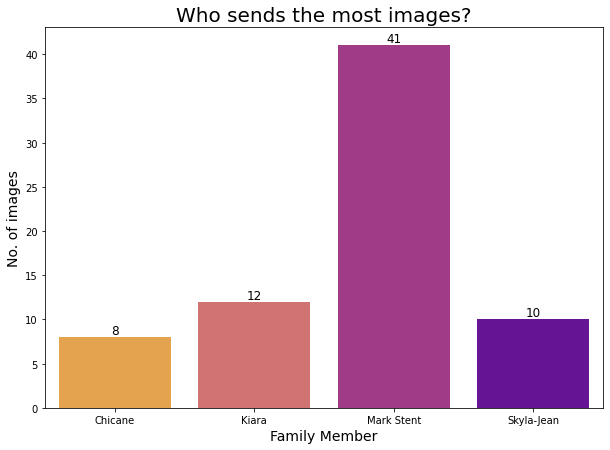

In [8]:
most_images = df.groupby('Author')['Media_image'].sum()

plt.figure(figsize=(10,7))
ax = sns.barplot(x=most_images.index.categories[:-1], y=most_images.values[:-1],  palette='plasma_r')
plt.xlabel('Family Member' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of images',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Who sends the most images?',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12) #annotate bars
plt.show()


# Who sends the most voice notes?

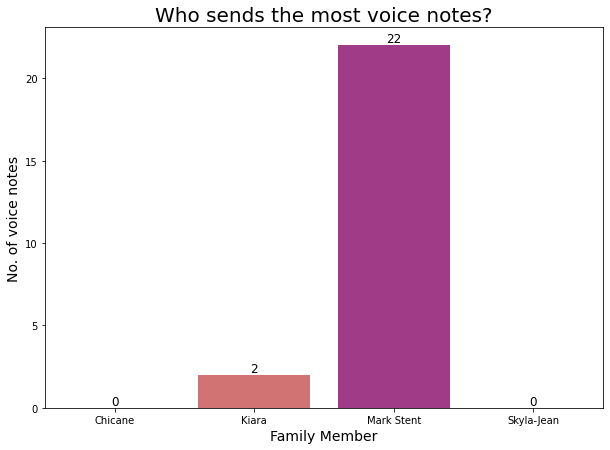

In [9]:
most_audio = df.groupby('Author')['Media_audio'].sum()

plt.figure(figsize=(10,7))
ax = sns.barplot(x=most_audio.index.categories[:-1], y=most_audio.values[:-1],  palette='plasma_r')
plt.xlabel('Family Member' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of voice notes',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Who sends the most voice notes?',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12) #annotate bars
plt.show()

## What are the most used words in our chats?

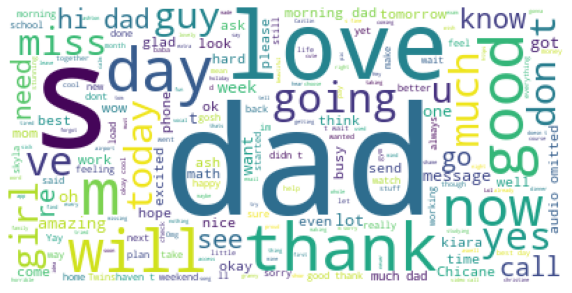

In [10]:
#Put all the text into one variable
from turtle import back


text = " ".join(x for x in df.Message)
text = text.replace('image omitted', "")
text = text.replace('video omitted', "")

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text) #create a Wordcloud object
#Display the image

plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



(Glad to see that 'dad', 'love' and 'good' rank so highly!)

## What is our most popular time for chatting?

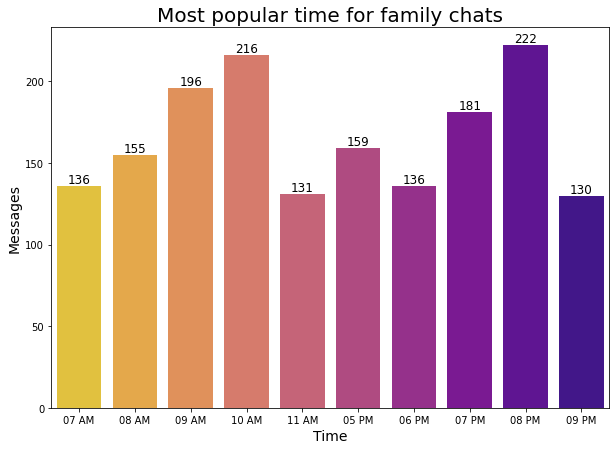

In [11]:
t = df['Time_Rounded'].value_counts().head(10)
plt.figure(figsize=(10,7))
time_order = ['07 AM', '08 AM', '09 AM', '10 AM', '11 AM', '05 PM', '06 PM', '07 PM', '08 PM', '09 PM']
ax = sns.barplot(x=t.index, y=t.values,  palette='plasma_r', order=time_order)
plt.xlabel('Time' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('Messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Most popular time for family chats',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12) #annotate bars
plt.show()



## What Emoji's are used most in the chat?

(for some reason the ❤️   is not coming up in the analysis, if you know why, hit me up!)

In [35]:
total_emoji = list([a for b in df.Emoji for a in b])
e_dict = dict(Counter(total_emoji))
e_list = sorted(e_dict.items(), key=lambda x: x[1], reverse=True)
e_df = pd.DataFrame(e_list, columns=['Emoji', 'Number'])
e_df.index = np.arange(1, len(e_df) + 1)
e_df['Emoji']

1     🤣
2     😍
3     💓
4     🥰
5     😭
6     🔥
7     🥺
8     😬
9     💘
10    💝
11    🥳
12    😀
13    😐
14    💋
Name: Emoji, dtype: object

## How does our message frequency look over time?

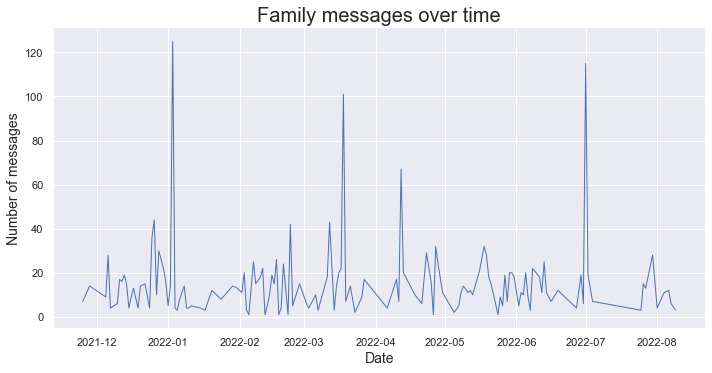

In [14]:
df_date = df.groupby('Date')['Message'].count()

color = (sns.dark_palette("purple"))
sns.set()

sns.relplot(x=df_date.index, y=df_date.values, kind='line', aspect=2, height=5, 
                  palette=sns.color_palette('coolwarm', n_colors=5), lw=1)
plt.xlabel("Date",fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel("Number of messages",fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Family messages over time',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

## What is the tone of the conversation?

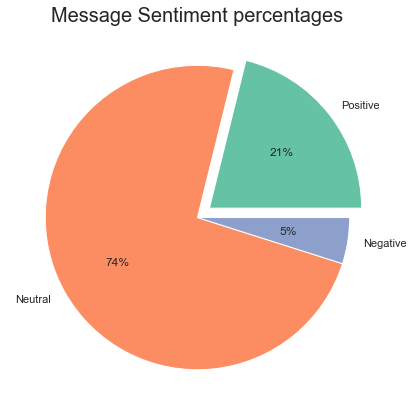

In [15]:
# Extract sentiment for each message

sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Message"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Message"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Message"]]

data = [df["Positive"].mean(), df["Neutral"].mean(), df["Negative"].mean()]
keys = ['Positive', 'Neutral', 'Negative']  
plt.figure(figsize=(10,7))  
explode = [0.1, 0, 0]        
plt.pie(data, labels=keys, autopct='%.0f%%', explode = explode, colors=sns.color_palette("Set2"))
plt.title('Message Sentiment percentages',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()


# Who types the most, proportionately?

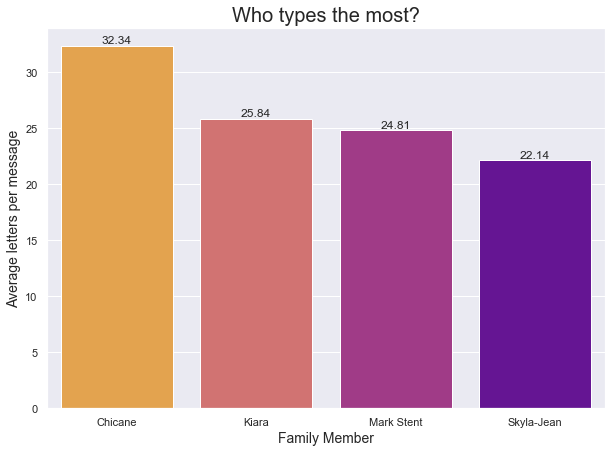

In [16]:
most_typing = df.groupby('Author').apply(lambda x: (x['letters']/x['Message'].count()).sum())

plt.figure(figsize=(10,7))
ax = sns.barplot(x=most_typing.index.categories[:-1], y=most_typing.values[:-1],  palette='plasma_r')
plt.xlabel('Family Member' ,fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('Average letters per message',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Who types the most?',fontdict={'fontsize': 20,'fontweight': 8})
plt.ticklabel_format(style='plain', axis='y')
ax.bar_label(ax.containers[0], size = 12, fmt='%.2f') #annotate bars
plt.show()